In [1]:
import numpy as np
import instrument as ins
import isochrones as iso
import galaxy as gal
import driver
import matplotlib.pyplot as plt
import matplotlib as mpl
# from scipy.stats import poisson
import time
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl


GPU acceleration enabled


Message: trial mode expires in 30 days
/n/home01/bcook/.conda/envs/my_home/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
reload(driver)

In [2]:
def plot_pixcmd(colors, mags, ax=None, colorbar=True):
    if ax is None:
        fig, ax = plt.subplots()
    plt.subplot(ax)
    plt.hist2d(colors, mags, bins=150, cmap='viridis', norm=mpl.colors.LogNorm())
    if colorbar:
        plt.colorbar(label='Pixel Counts')
    return ax

In [3]:
im_scale = 512
filters = [ins.Filter.HST_F475W(1.), ins.Filter.HST_F814W(1.)]
n_filters = len(filters)

In [4]:
iso_model = iso.Isochrone_Model(filters)
gal_model_complex = gal.Galaxy_Model(1e2, np.array([6.5, 7.5, 8.25, 8.75, 9.25, 9.75, 10.1]), np.array([0.,1.,1.,1.,1.,1.,1.]), 0., 0.)
gal_model_simple = gal.Galaxy_Model(1e2, np.array([10.]), np.array([1.]), 0., 0.)

In [5]:
driver_cpu = driver.Driver(iso_model, gpu=False)
driver_gpu = driver.Driver(iso_model, gpu=True)

In [6]:
%%time
raw_mags_c, mags_c, raw_images_c, images_c = driver_cpu.simulate(gal_model_simple, 1024)

CPU times: user 15.3 s, sys: 1.69 s, total: 17 s
Wall time: 17 s


In [7]:
%%time
raw_mags_g, mags_g, raw_images_g, images_g = driver_gpu.simulate(gal_model_simple, 1024)

CPU times: user 2.97 s, sys: 1.98 s, total: 4.95 s
Wall time: 5.3 s


In [20]:
%%time
raw_mags_g, mags_g, raw_images_g, images_g = driver_gpu.simulate(gal_model_simple, 4096)

CPU times: user 42.9 s, sys: 1min 4s, total: 1min 47s
Wall time: 1min 47s


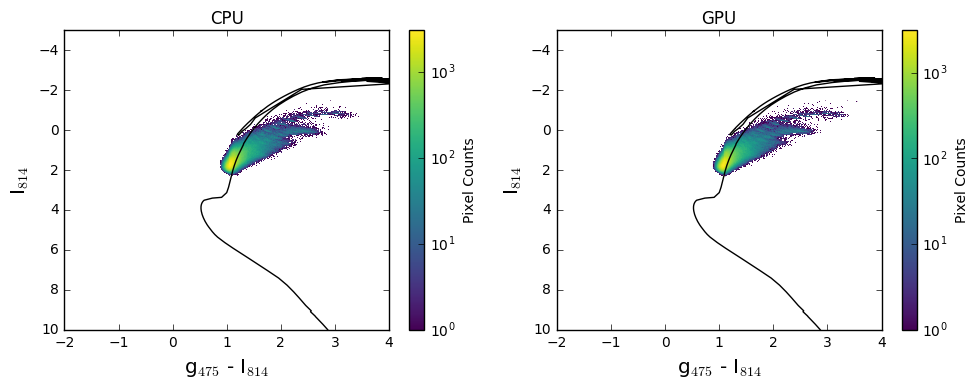

In [8]:
fig, axes = plt.subplots(figsize=(10,4), ncols=2)
plot_pixcmd(mags_c[0]-mags_c[1], mags_c[1], ax=axes[0], colorbar=True)
plot_pixcmd(mags_g[0]-mags_g[1], mags_g[1], ax=axes[1])
iso_model.plot_isochrone(gal_model_simple, ax=axes[0])
iso_model.plot_isochrone(gal_model_simple, ax=axes[1])
axes[0].set_ylim([10, -5])
axes[0].set_xlim([-2, 4])
axes[1].set_ylim([10, -5])
axes[1].set_xlim([-2, 4])
axes[0].set_title('CPU'), axes[1].set_title('GPU')
plt.tight_layout()
# plt.savefig('../../sandbox/2b_PSF.pdf')

In [9]:
%%time
raw_mags_c, mags_c, raw_images_c, images_c = driver_cpu.simulate(gal_model_complex, 512)

CPU times: user 19.4 s, sys: 3.49 s, total: 22.9 s
Wall time: 28 s


In [10]:
%%time
raw_mags_g, mags_g, raw_images_g, images_g = driver_gpu.simulate(gal_model_complex, 512)

CPU times: user 3.67 s, sys: 845 ms, total: 4.52 s
Wall time: 5.98 s


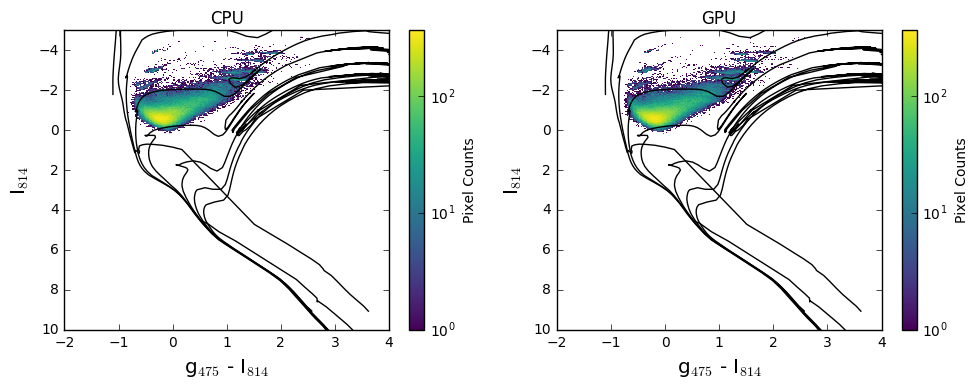

In [11]:
fig, axes = plt.subplots(figsize=(10,4), ncols=2)
plot_pixcmd(mags_c[0]-mags_c[1], mags_c[1], ax=axes[0], colorbar=True)
plot_pixcmd(mags_g[0]-mags_g[1], mags_g[1], ax=axes[1])
iso_model.plot_isochrone(gal_model_complex, ax=axes[0])
iso_model.plot_isochrone(gal_model_complex, ax=axes[1])
axes[0].set_ylim([10, -5])
axes[0].set_xlim([-2, 4])
axes[1].set_ylim([10, -5])
axes[1].set_xlim([-2, 4])
axes[0].set_title('CPU'), axes[1].set_title('GPU')
plt.tight_layout()
# plt.savefig('../../sandbox/2b_PSF.pdf')

In [21]:
scale_arr = [128, 256, 512, 1024, 2048, 4096]

t_cpu_simple = np.zeros_like(scale_arr, dtype=float)
t_gpu_simple = np.zeros_like(scale_arr, dtype=float)
t_cpu_complex = np.zeros_like(scale_arr, dtype=float)
t_gpu_complex = np.zeros_like(scale_arr, dtype=float)

In [ ]:
for i, scale in enumerate(scale_arr):
    print('Evaluating %d pixels'%(scale))
    if (scale < 2048):
        print('---CPU Simple')
        start = time.time()
        _ = driver_cpu.simulate(gal_model_simple, scale)
        t_cpu_simple[i] = time.time() - start
    if (scale < 1024):
        print('---CPU Complex')
        start = time.time()
        _ = driver_cpu.simulate(gal_model_complex, scale)
        t_cpu_complex[i] = time.time() - start
    print('---GPU Simple')
    start = time.time()
    _ = driver_gpu.simulate(gal_model_simple, scale)
    t_gpu_simple[i] = time.time() - start
    print('---GPU Complex')
    start = time.time()
    _ = driver_gpu.simulate(gal_model_complex, scale)
    t_gpu_complex[i] = time.time() - start

Evaluating 128 pixels
---CPU Simple
---CPU Complex
---GPU Simple
---GPU Complex
Evaluating 256 pixels
---CPU Simple
---CPU Complex
---GPU Simple
---GPU Complex
Evaluating 512 pixels
---CPU Simple
---CPU Complex
---GPU Simple
---GPU Complex
Evaluating 1024 pixels
---CPU Simple
---GPU Simple
---GPU Complex
Evaluating 2048 pixels
---GPU Simple
---GPU Complex
Evaluating 4096 pixels
---GPU Simple
---GPU Complex


In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(scale_arr[:-1], t_cpu_simple[:-1], 'ro', ls='-', label='CPU, SSP')
ax.plot(scale_arr[:-2], t_cpu_complex[:-2], 'r*', ls='--', label='CPU, Complex')
ax.plot(scale_arr, t_gpu_simple, 'bo', ls='-', label='GPU, SSP')
ax.plot(scale_arr, t_gpu_complex, 'b*', ls='--', label='GPU, Complex')
ax.legend(loc=4)
ax.set_xlabel('Image Scale (NxN pixels)', fontsize='xx-large')
# ax.set_xscale('log')
ax.set_xticks(scale_arr)
ax.set_ylabel('Time Elapsed (s)', fontsize='xx-large')
ax.set_yscale('log')